# **CS224W - Colab 5**

In this Colab we will experiment on scaling up GNNs using PyTorch Geometric, DeepSNAP and NetworkX. As we have **canceled** the Colab 5 assignment, this notebook will be a tutorial and you do not need to submit it on Gradescope.

At first, we will use PyTorch Geometric `NeighborSampler` to scale up the training and testing on OGB `arxiv` dataset.

Then, using the DeepSNAP and NetworkX, we will implement a simplified version of `NeighborSampler` and run experiments with different smapling ratios on the Cora graph.

At last, we will partition the Cora graph into clusters by using different partition algorithms and then train the models in the way of vanilla Cluster-GCN.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell

# **CS224W - Colab 5**

这个 Colab 主要内容为使用 PyTorch Gemetric、DeepSNAP、NetworkX 来拓展（Scaling up） GNNs。


首先，我们将使用 PyTorch Geometric `NeighborSampler` 来扩展 OGB `arxiv` 数据集的训练和测试。

然后，使用 DeepSNAP 和 NetworkX，我们将实现 `NeighborSampler` 的简化版本，并在 Cora 图上使用不同的采样率运行实验。

最后，我们将使用不同的划分算法将 Cora 图划分为簇，然后以 vanilla Cluster-GCN 的方式训练模型。

**注意**：确保**依次运行每个部分中的所有单元格**，以便中间变量/包会延续到下一个单元格


# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
'''!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb
!pip install -q git+https://github.com/snap-stanford/deepsnap.git'''

'!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html\n!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html\n!pip install -q torch-geometric\n!pip install -q ogb\n!pip install -q git+https://github.com/snap-stanford/deepsnap.git'

In [2]:
import torch_geometric
torch_geometric.__version__

'1.7.1'

# 1 PyTorch Geometric Neighbor Sampling

Neighbor Sampling, originally proposed in **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), is a representative method to scale up GNNs. As what we have learned in lecture, only a K-hop neighborhood nodes will be loaded into GPU for each time training. To further reduce the cost, we can sample a subset of neighborhood nodes for GNNs to aggregate.

# 1 PyTorch Geometric 邻域采样

邻域采样, 最早提出于 **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)), 是一种拓展 GNN 的代表性方法. 
正如我们在课程中学习的那样，在每次训练迭代时只有一个 K-hop 邻域会被加载到 GPU 中。为了更进一步降低损失，我们可以采样一个邻居节点的子集喂给 GNN 去聚合。


## Setup

In [3]:
import copy
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch_geometric.nn import SAGEConv
from torch_geometric.data import NeighborSampler
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

## Neighbor Sampler

PyTorch Geometric has implemented the Neighbor Sampling method as the [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.NeighborSampler) in `torch_geometric.data`. Following is an example that uses the Neighbor Sampling method on training the OGB `arxiv` dataset.

If you are interested in memory-efficient aggregations, please refer to PyG's [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).

## Neighbor Sampler

在 `torch_geometric.data` 中，PyTorch Geometric 已经实现了领域采样方法 [NeighborSampler](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.NeighborSampler)。
接下来就是一个使用邻域采样方法训练 OGB `arxiv` 数据集的例子。

如果你对 memory-efficient 聚合感兴趣，请参考 PyG 的 [Memory-Efficient Aggregations](https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html).

In [4]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 transform=T.ToSparseTensor(),
                                 root='./datasets')
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Device: {}'.format(device))

data = data.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

# Construct the training dataloader for training data
# Sample 10 neighbors for each node in the first layer and 5 for the second layer
# 构建训练数据的 dataloader, 
# 在第一层采样 10 个邻居，在第二层采样 5 个邻居
train_loader = NeighborSampler(data.adj_t, node_idx=train_idx,
                               sizes=[10, 5], batch_size=4096,
                               shuffle=True, num_workers=2)

# Specify size as -1 to include all neighbors
# 指定 sizes = -1 就可以采样所有邻居
all_loader = NeighborSampler(data.adj_t, node_idx=None, sizes=[-1],
                                  batch_size=4096, shuffle=False,
                                  num_workers=2)
evaluator = Evaluator(name='ogbn-arxiv')

Device: cuda


## GNN Model

After creating the `NeighborSampler`, we also need to modify the model to let it support the mini-batch training.

The `forward` function will take the node feature `x` and a list of three-element tuples `adjs`. Each element in `adjs` contains following elements:
* `edge_index`: The edge index tensor between source and destination nodes, which forms a bipartite grpah.
* `e_id`: The indices of the edges in the original graph.
* `size`: The shape of the bipartite graph, in (*number of source nodes*, *number of destination nodes*) format.

## GNN 模型

在创建After creating the `NeighborSampler`, 我们还需要修改一下模型以适应 mini-batch 训练。

`forward` 函数将接收节点特征 `x` 和一个三元组列表 `adjs` 作为输入。`adjs` 的每个元素都包含如下元素（即列表中的每个元组都包含如下三个元素）:
* `edge_index`: 在源节点和目标节点之间的边索引 Tensor，这形成了一个二部图。
* `e_id`: 在原图中边的索引。
* `size`: 二部图的形状, 大概是 (*源节点数*, *目标节点数*) 的格式。

In [5]:
class SAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.bns = torch.nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

        for i in range(num_layers - 2):
            self.convs.append(
                SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(torch.nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, output_dim))

        self.softmax = torch.nn.LogSoftmax(dim=1)

        self.dropout = dropout

        self.num_layers = num_layers

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adjs, mode="batch"):
        if mode == "batch":
            for i, (edge_index, _, size) in enumerate(adjs):
                # Extract target node features
                x_target = x[:size[1]]

                # Update x for next layer reuse
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        else:
            for i, conv in enumerate(self.convs):
                x = conv(x, adjs)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
        return self.softmax(x)
    
    def inference(self, x_all, all_loader):
        # This function will be called in test
        # 测试时调用这个函数哦
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in all_loader:
                edge_index, _, size = adj.to(device)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                if i != self.num_layers - 1:
                    x = self.bns[i](x)
                    x = F.relu(x)
                    x = F.dropout(x, p=self.dropout, training=self.training)
                
                # Append the node embeddings to xs
                xs.append(x.cpu())
            
            # Concat all embeddings into one tensor
            x_all = torch.cat(xs, dim=0)

        return x_all

## Training and Testing

Now lets implement the training and testing functions.

In both training and testing, we need to sample batch from the dataloader.

Each batch in the `NeighborSampler` dataloader holds three elements:
* `batch_size`: The batch size specified in the dataloader.
* `n_id`: All nodes (in index format) used in the adjacency matrices.
* `adjs`: The three-element tuples.

## 训练与测试

现在来实现训练与测试函数

在训练和测试时，都需要从 dataloader 中采样 batch

对于 `NeighborSampler` dataloader 中的每个 batch，都有三个元素：

* `batch_size`: dataloader 中指定的 batch size.
* `n_id`: 邻接矩阵中用到的所有节点 (以索引形式) 。
* `adjs`: 三元组（edge_index, e_id, size）.

In [7]:
def train(model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch"):
    model.train()

    total_loss = 0
    if mode == "batch":
        for batch_size, n_id, adjs in train_loader:
            # Move all adj sparse tensors to GPU
            # 将所有的 adj 稀疏 Tensor 移到 GPU 
            adjs = [adj.to(device) for adj in adjs]
            optimizer.zero_grad()

            # Index on the node features
            out = model(data.x[n_id], adjs)
            train_label = data.y[n_id[:batch_size]].squeeze(-1)
            loss = loss_fn(out, train_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    else:
        optimizer.zero_grad()
        out = model(data.x, data.adj_t, mode=mode)[train_idx]
        train_label = data.y.squeeze(1)[train_idx]
        loss = loss_fn(out, train_label)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()

    return total_loss

@torch.no_grad()
def test(model, data, all_loader, split_idx, evaluator, mode="batch"):
    model.eval()

    if mode == "batch":
        out = model.inference(data.x, all_loader)
    else:
        out = model(data.x, data.adj_t, mode="all")

    y_true = data.y.cpu()
    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': y_true[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': y_true[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': y_true[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

## Mini-batch Training

In [9]:
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

batch_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
batch_model.reset_parameters()

optimizer = torch.optim.Adam(batch_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_batch_model = None
best_valid_acc = 0

batch_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(batch_model, data, train_loader, train_idx, optimizer, loss_fn, mode="batch")
    result = test(batch_model, data, all_loader, split_idx, evaluator, mode="batch")
    batch_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_batch_model = copy.deepcopy(batch_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_batch_model, data, all_loader, split_idx, evaluator, mode="batch")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 39.7756, Train: 63.22%, Valid: 64.58% Test: 64.80%
Epoch: 02, Loss: 28.4881, Train: 67.21%, Valid: 67.25% Test: 66.46%
Epoch: 03, Loss: 26.5656, Train: 68.81%, Valid: 68.31% Test: 67.11%
Epoch: 04, Loss: 25.5290, Train: 69.79%, Valid: 68.65% Test: 66.89%
Epoch: 05, Loss: 24.9556, Train: 70.24%, Valid: 69.50% Test: 68.79%
Epoch: 06, Loss: 24.5641, Train: 70.75%, Valid: 68.75% Test: 66.57%
Epoch: 07, Loss: 24.2491, Train: 71.63%, Valid: 69.70% Test: 69.07%
Epoch: 08, Loss: 23.8724, Train: 71.70%, Valid: 70.35% Test: 70.08%
Epoch: 09, Loss: 23.7982, Train: 72.15%, Valid: 69.74% Test: 68.08%
Epoch: 10, Loss: 23.3939, Train: 71.93%, Valid: 70.14% Test: 69.58%
Epoch: 11, Loss: 23.3046, Train: 72.51%, Valid: 69.65% Test: 67.86%
Epoch: 12, Loss: 23.1149, Train: 72.79%, Valid: 70.09% Test: 68.96%
Epoch: 13, Loss: 23.0383, Train: 72.84%, Valid: 68.93% Test: 66.96%
Epoch: 14, Loss: 22.8687, Train: 73.10%, Valid: 70.05% Test: 69.23%
Epoch: 15, Loss: 22.8408, Train: 73.46%, Valid: 

## Full-batch Training

In [10]:
# Use the same parameters for a full-batch training
args = {
    'device': device,
    'num_layers': 2,
    'hidden_dim': 128,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
}

all_model = SAGE(data.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
all_model.reset_parameters()

optimizer = torch.optim.Adam(all_model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss

best_all_model = None
best_valid_acc = 0

all_results = []

for epoch in range(1, 1 + args["epochs"]):
    loss = train(all_model, data, train_loader, train_idx, optimizer, loss_fn, mode="all")
    result = test(all_model, data, all_loader, split_idx, evaluator, mode="all")
    all_results.append(result)
    train_acc, valid_acc, test_acc = result
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        best_all_model = copy.deepcopy(all_model)
    print(f'Epoch: {epoch:02d}, '
          f'Loss: {loss:.4f}, '
          f'Train: {100 * train_acc:.2f}%, '
          f'Valid: {100 * valid_acc:.2f}% '
          f'Test: {100 * test_acc:.2f}%')
best_result = test(best_all_model, data, all_loader, split_idx, evaluator, mode="all")
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * valid_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.9182, Train: 23.37%, Valid: 19.91% Test: 21.12%
Epoch: 02, Loss: 2.6220, Train: 32.98%, Valid: 39.59% Test: 41.94%
Epoch: 03, Loss: 2.2396, Train: 33.34%, Valid: 40.48% Test: 42.66%
Epoch: 04, Loss: 2.0535, Train: 33.86%, Valid: 41.65% Test: 44.73%
Epoch: 05, Loss: 1.9094, Train: 34.82%, Valid: 40.77% Test: 44.51%
Epoch: 06, Loss: 1.8001, Train: 37.58%, Valid: 41.12% Test: 45.30%
Epoch: 07, Loss: 1.7089, Train: 43.09%, Valid: 45.99% Test: 49.67%
Epoch: 08, Loss: 1.6360, Train: 49.05%, Valid: 52.84% Test: 55.26%
Epoch: 09, Loss: 1.5789, Train: 53.56%, Valid: 57.58% Test: 59.32%
Epoch: 10, Loss: 1.5304, Train: 56.26%, Valid: 60.13% Test: 61.21%
Epoch: 11, Loss: 1.4898, Train: 57.82%, Valid: 61.11% Test: 61.70%
Epoch: 12, Loss: 1.4515, Train: 58.76%, Valid: 61.72% Test: 61.90%
Epoch: 13, Loss: 1.4188, Train: 59.56%, Valid: 61.88% Test: 61.96%
Epoch: 14, Loss: 1.3975, Train: 60.35%, Valid: 62.13% Test: 61.90%
Epoch: 15, Loss: 1.3776, Train: 61.22%, Valid: 62.39% Test: 61

## Visualization

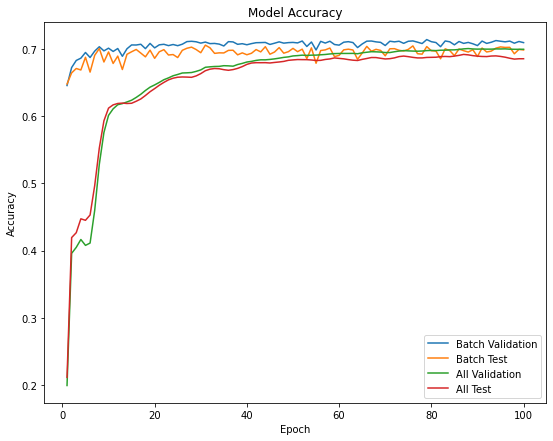

In [11]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_results)
all_results = np.array(all_results)

x = np.arange(1, 101)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 1], label="Batch Validation")
plt.plot(x, batch_results[:, 2], label="Batch Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# 2 Neighbor Sampling with Different Ratios

Now we will implement a simplified version of Neighbor Sampling by using DeepSNAP and NetworkX, and train models with different neighborhood sampling ratios.

To make the experiments faster, we will use the Cora graph here.

# 2 不同比率的邻域采样

现在我们将使用 DeepSNAP 和 NetworkX 实现一个简化版的 Neighbor Sampling, 并且使用不同的领域采样率训练模型。

为了让实验跑的更快，我们将使用 Cora 数据集。

In [12]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./datasets', "Cora")

## GNN Model

In [13]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args):
        super(GNN, self).__init__()
        self.dropout = args['dropout']
        self.num_layers = args['num_layers']

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(SAGEConv(input_dim, hidden_dim))
        self.bns.append(nn.BatchNorm1d(hidden_dim))

        for l in range(self.num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
            self.bns.append(nn.BatchNorm1d(hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.post_mp = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, mode="batch"):
        if mode == "batch":
            edge_indices, x = data
            for i in range(len(self.convs) - 1):
                edge_index = edge_indices[i]
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_indices[len(self.convs) - 1])
        else:
            x, edge_index = data.node_feature, data.edge_index
            for i in range(len(self.convs) - 1):
                x = self.convs[i](x, edge_index)
                x = self.bns[i](x)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
            x = self.convs[-1](x, edge_index)
        x = self.post_mp(x)
        x = F.log_softmax(x, dim=1)
        return x

## Neighbor Sampling

Here we implement functions that will sample neighbors by using DeepSNAP and NetworkX.

Notice that node classification task on Cora is a semi-supervised classification task, here we keep all the labeled training nodes (140 nodes) by setting the last ratio to 1.

## Neighbor Sampling

这里我们实现一个能够使用 DeepSNAP 和 NetworkX 采样邻域的函数。

注意 Cora 上的节点分类任务是半监督任务，所以我们通过设置最终比例为 1 来保持所有有标签的训练节点（共 140 个）


In [14]:
def sample_neighbors(nodes, G, ratio, all_nodes):
    # This fuction takes a set of nodes, a NetworkX graph G and neighbor sampling ratio.
    # It will return sampled neighbors (unioned with input nodes) and edges between 
    '''
    这个函数将一个节点的集合作为输入，一个 NetworkX 图 G 以及邻域采样比 ratio 作为输入。
    返回被采样到的邻域（包含输入点）以及中间的边
    '''
    
    neighbors = set()
    edges = []
    for node in nodes:
        neighbors_list = list(nx.neighbors(G, node))

        # We only sample the (ratio * number of neighbors) neighbors
        # 我们只采样  (ratio * number of neighbors) 个邻居
        num = int(len(neighbors_list) * ratio)
        if num > 0:
            # Random shuffle the neighbors
            random.shuffle(neighbors_list)
            neighbors_list = neighbors_list[:num]
            for neighbor in neighbors_list:
                # Add neighbors
                neighbors.add(neighbor)
                edges.append((neighbor, node))
    return neighbors, neighbors.union(all_nodes), edges

def nodes_to_tensor(nodes):
    # This function transform a set of nodes to node index tensor
    # 这个函数将一个节点的集合转换为节点索引 Tensor
    node_label_index = torch.tensor(list(nodes), dtype=torch.long)
    return node_label_index

def edges_to_tensor(edges):
    # This function transform a set of edges to edge index tensor
    # 转换边的集合为边索引 Tensor
    edge_index = torch.tensor(list(edges), dtype=torch.long)
    edge_index = torch.cat([edge_index, torch.flip(edge_index, [1])], dim=0)
    edge_index = edge_index.permute(1, 0)
    return edge_index

def relable(nodes, labeled_nodes, edges_list):
    # Relable the nodes, labeled_nodes and edges_list
    # 重新标记 nodes， labeled_nodes 以及 edges_list
    relabled_edges_list = []
    sorted_nodes = sorted(nodes)
    node_mapping = {node : i for i, node in enumerate(sorted_nodes)}
    for orig_edges in edges_list:
        relabeled_edges = []
        for edge in orig_edges:
            relabeled_edges.append((node_mapping[edge[0]], node_mapping[edge[1]]))
        relabled_edges_list.append(relabeled_edges)
    relabeled_labeled_nodes = [node_mapping[node] for node in labeled_nodes]
    relabeled_nodes = [node_mapping[node] for node in nodes]
    return relabled_edges_list, relabeled_nodes, relabeled_labeled_nodes

def neighbor_sampling(graph, K=2, ratios=(0.1, 0.1, 0.1)):
    # This function takes a DeepSNAP graph, K the number of GNN layers, and neighbor 
    # sampling ratios for each layer. This function returns relabeled node feature, 
    # edge indices and node_label_index
    '''
    这个函数接受一个 DeepSNAP 图、 GNN 层数 K，以及每一层的邻域采样率作为输入，
    返回重新标记的节点特征、边索引以及节点标签索引
    '''
    assert K + 1 == len(ratios)

    labeled_nodes = graph.node_label_index.tolist()
    random.shuffle(labeled_nodes)
    num = int(len(labeled_nodes) * ratios[-1])
    if num > 0:
        labeled_nodes = labeled_nodes[:num]
    nodes_list = [set(labeled_nodes)]
    edges_list = []
    all_nodes = labeled_nodes
    for k in range(K):
        # Get nodes and edges from the previous layer
        # 从之前的层获取边和节点
        nodes, all_nodes, edges = \
            sample_neighbors(nodes_list[-1], graph.G, ratios[len(ratios) - k - 2], all_nodes)
        nodes_list.append(nodes)
        edges_list.append(edges)
    
    # Reverse the lists
    # 反转列表（Why？）
    nodes_list.reverse()
    edges_list.reverse()

    relabled_edges_list, relabeled_all_nodes, relabeled_labeled_nodes = \
        relable(all_nodes, labeled_nodes, edges_list)

    node_index = nodes_to_tensor(relabeled_all_nodes)
    # All node features that will be used
    # 所有的节点特征都会用上。
    node_feature = graph.node_feature[node_index]
    edge_indices = [edges_to_tensor(edges) for edges in relabled_edges_list]
    node_label_index = nodes_to_tensor(relabeled_labeled_nodes)
    log = "Sampled {} nodes, {} edges, {} labeled nodes"
    print(log.format(node_feature.shape[0], edge_indices[0].shape[1] // 2, node_label_index.shape[0]))
    return node_feature, edge_indices, node_label_index

## Training and Testing

In [15]:
def train(train_graphs, val_graphs, args, model, optimizer, mode="batch"):
    best_val = 0
    best_model = None
    accs = []
    graph_train = train_graphs[0]
    graph_train.to(args['device'])
    for epoch in range(1, 1 + args['epochs']):
        model.train()
        optimizer.zero_grad()
        if mode == "batch":
            node_feature, edge_indices, node_label_index = neighbor_sampling(graph_train, args['num_layers'], args['ratios'])
            node_feature = node_feature.to(args['device'])
            node_label_index = node_label_index.to(args['device'])
            for i in range(len(edge_indices)):
                edge_indices[i] = edge_indices[i].to(args['device'])
            pred = model([edge_indices, node_feature])
            pred = pred[node_label_index]
            label = graph_train.node_label[node_label_index]
        elif mode == "community":
            graph = random.choice(train_graphs)
            graph = graph.to(args['device'])
            pred = model(graph, mode="all")
            pred = pred[graph.node_label_index]
            label = graph.node_label[graph.node_label_index]
        else:
            pred = model(graph_train, mode="all")
            label = graph_train.node_label
            pred = pred[graph_train.node_label_index]
        loss = F.nll_loss(pred, label)
        loss.backward()
        optimizer.step()

        train_acc, val_acc, test_acc = test(val_graphs, model)
        accs.append((train_acc, val_acc, test_acc))
        if val_acc > best_val:
            best_val = val_acc
            best_model = copy.deepcopy(model)
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * val_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')
    return best_model, accs

def test(graphs, model):
    model.eval()
    accs = []
    for graph in graphs:
        graph = graph.to(args['device'])
        pred = model(graph, mode="all")
        label = graph.node_label
        pred = pred[graph.node_label_index].max(1)[1]
        acc = pred.eq(label).sum().item()
        acc /= len(label)
        accs.append(acc)
    return accs

In [16]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 50,
    'ratios': (0.8, 0.8, 1),
}

## Full-Batch Training

In [17]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0030, Train: 48.57%, Valid: 15.00% Test: 18.50%
Epoch: 02, Loss: 1.1418, Train: 90.00%, Valid: 27.20% Test: 30.50%
Epoch: 03, Loss: 0.6011, Train: 99.29%, Valid: 43.80% Test: 46.70%
Epoch: 04, Loss: 0.3102, Train: 100.00%, Valid: 53.20% Test: 55.50%
Epoch: 05, Loss: 0.1662, Train: 100.00%, Valid: 60.20% Test: 60.70%
Epoch: 06, Loss: 0.0835, Train: 100.00%, Valid: 64.80% Test: 65.00%
Epoch: 07, Loss: 0.0430, Train: 100.00%, Valid: 67.20% Test: 66.50%
Epoch: 08, Loss: 0.0252, Train: 100.00%, Valid: 68.60% Test: 69.20%
Epoch: 09, Loss: 0.0132, Train: 100.00%, Valid: 70.40% Test: 70.30%
Epoch: 10, Loss: 0.0074, Train: 100.00%, Valid: 70.80% Test: 71.40%
Epoch: 11, Loss: 0.0070, Train: 100.00%, Valid: 71.60% Test: 72.10%
Epoch: 12, Loss: 0.0035, Train: 100.00%, Valid: 72.20% Test: 72.40%
Epoch: 13, Loss: 0.0037, Train: 100.00%, Valid: 72.40% Test: 72.80%
Epoch: 14, Loss: 0.0

## Sampling with Ratios 0.8

In [18]:
args['ratios'] = (0.8, 0.8, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 1291 nodes, 1983 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0402, Train: 32.86%, Valid: 14.80% Test: 15.50%
Sampled 1298 nodes, 2005 edges, 140 labeled nodes
Epoch: 02, Loss: 1.6077, Train: 63.57%, Valid: 16.60% Test: 19.40%
Sampled 1342 nodes, 2045 edges, 140 labeled nodes
Epoch: 03, Loss: 1.3821, Train: 81.43%, Valid: 23.40% Test: 26.20%
Sampled 1336 nodes, 2009 edges, 140 labeled nodes
Epoch: 04, Loss: 1.1093, Train: 86.43%, Valid: 28.20% Test: 28.30%
Sampled 1327 nodes, 1976 edges, 140 labeled nodes
Epoch: 05, Loss: 0.8865, Train: 92.14%, Valid: 32.80% Test: 32.10%
Sampled 1314 nodes, 2048 edges, 140 labeled nodes
Epoch: 06, Loss: 0.6842, Train: 95.00%, Valid: 35.60% Test: 36.70%
Sampled 1321 nodes, 1972 edges, 140 labeled nodes
Epoch: 07, Loss: 0.5067, Train: 97.86%, Valid: 39.80% Test: 40.80%
Sampled 1288 nodes, 1979 edges, 140 labeled nodes
Epoch: 08, Loss: 0.4591, Train: 

## Sampling with Ratios 0.3

In [19]:
# Change the ratio to 0.3
args['ratios'] = (0.3, 0.3, 1)

graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
batch_best_model, batch_accs_1 = train(graphs, graphs, args, model, optimizer)
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], batch_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Sampled 446 nodes, 259 edges, 140 labeled nodes
Epoch: 01, Loss: 2.0585, Train: 14.29%, Valid: 31.60% Test: 31.70%
Sampled 428 nodes, 255 edges, 140 labeled nodes
Epoch: 02, Loss: 1.9720, Train: 19.29%, Valid: 31.80% Test: 32.70%
Sampled 396 nodes, 211 edges, 140 labeled nodes
Epoch: 03, Loss: 1.8495, Train: 27.14%, Valid: 33.80% Test: 32.90%
Sampled 439 nodes, 251 edges, 140 labeled nodes
Epoch: 04, Loss: 1.8715, Train: 37.86%, Valid: 31.00% Test: 31.80%
Sampled 420 nodes, 215 edges, 140 labeled nodes
Epoch: 05, Loss: 1.8499, Train: 39.29%, Valid: 28.40% Test: 27.80%
Sampled 420 nodes, 248 edges, 140 labeled nodes
Epoch: 06, Loss: 1.8047, Train: 39.29%, Valid: 25.00% Test: 25.90%
Sampled 433 nodes, 246 edges, 140 labeled nodes
Epoch: 07, Loss: 1.7381, Train: 39.29%, Valid: 21.60% Test: 24.30%
Sampled 436 nodes, 256 edges, 140 labeled nodes
Epoch: 08, Loss: 1.7476, Train: 45.71%, Valid: 2

## Visualization

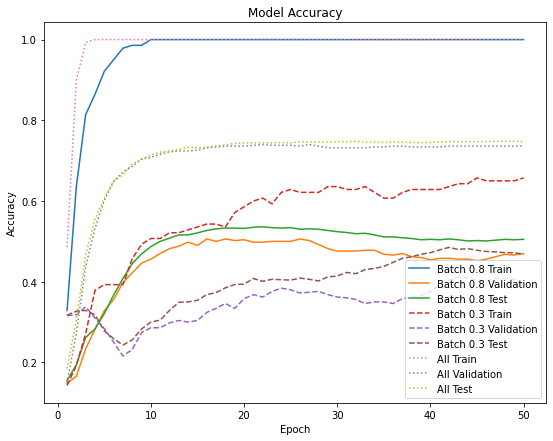

In [21]:
import numpy as np
from matplotlib import pyplot as plt

batch_results = np.array(batch_accs)
batch_results_1 = np.array(batch_accs_1)
all_results = np.array(all_accs)

x = np.arange(1, 51)

plt.figure(figsize=(9, 7))

plt.plot(x, batch_results[:, 0], label="Batch 0.8 Train")
plt.plot(x, batch_results[:, 1], label="Batch 0.8 Validation")
plt.plot(x, batch_results[:, 2], label="Batch 0.8 Test")
plt.plot(x, batch_results_1[:, 0], ls='--', label="Batch 0.3 Train")
plt.plot(x, batch_results_1[:, 1], ls='--', label="Batch 0.3 Validation")
plt.plot(x, batch_results_1[:, 2], ls='--', label="Batch 0.3 Test")
plt.plot(x, all_results[:, 0], ls=':', label="All Train")
plt.plot(x, all_results[:, 1], ls=':', label="All Validation")
plt.plot(x, all_results[:, 2], ls=':', label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

这里所有的准确率都通过 full-batch 模式评估。

# 3 Cluster Sampling

Instead of the neighbor sampling, we can use another approach, subgraph (cluster) sampling, to scale up GNN. This approach is proposed in Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)).

In this section, we will implement vanilla Cluster-GCN and experiment with 3 different community partition algorithms.

Notice that this section requires you have run the `Setup`, `GNN Model` and `Training and Testing` cells of the last section.

# 3 簇采样 Cluster Sampling

除了邻域采样，我们还可以使用其他方式, 子图 (簇) 采样, 以扩展 GNN。该方法首先被提出于 Cluster-GCN ([Chiang et al. (2019)](https://arxiv.org/abs/1905.07953)).

本节中，我们将实现 vanilla Cluster-GCN 以及使用 3 种不同的社区划分算法进行实验。

注意，本节中需要你已经运行上一节中的 `Setup`, `GNN Model` 以及 `Training and Testing`

## Setup

In [22]:
import copy
import torch
import random
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import community as community_louvain

from torch_geometric.nn import SAGEConv
from torch.utils.data import DataLoader
from torch_geometric.datasets import Planetoid
from torch.nn import Sequential, Linear, ReLU
from deepsnap.dataset import GraphDataset
from deepsnap.graph import Graph

pyg_dataset = Planetoid('./datasets', "Cora")

In [23]:
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'dropout': 0.5,
    'num_layers': 2,
    'hidden_size': 64,
    'lr': 0.005,
    'epochs': 150,
}

## Partition the Graph into Clusters

Here we use following three community detection / partition algorithms to partition the graph into different clusters:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


To make the training more stable, we discard the cluster that has less than 10 nodes.

Let's first define these algorithms as DeepSNAP transformation on a graph.

## 将图划分为簇

这里我们使用如下三个社区检测 / 分割算法以疆土划分为不同的簇:
* [Kernighan–Lin algorithm (bisection)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.kernighan_lin.kernighan_lin_bisection.html)
* [Clauset-Newman-Moore greedy modularity maximization](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.modularity_max.greedy_modularity_communities.html#networkx.algorithms.community.modularity_max.greedy_modularity_communities)
* [Louvain algorithm](https://python-louvain.readthedocs.io/en/latest/api.html)


为了稳定训练，我们抛弃了少于 10 个节点的簇。

首先我们将这些算法定义为 DeepSNAP 的 Transformation

In [24]:
def preprocess(G, node_label_index, method="louvain"):
    graphs = []
    labeled_nodes = set(node_label_index.tolist())
    if method == "louvain":
        community_mapping = community_louvain.best_partition(G, resolution=10)
        communities = {}
        for node in community_mapping:
            comm = community_mapping[node]
            if comm in communities:
                communities[comm].add(node)
            else:
                communities[comm] = set([node])
        communities = communities.values()
    elif method == "bisection":
        communities = nx.algorithms.community.kernighan_lin_bisection(G)
    elif method == "greedy":
        communities = nx.algorithms.community.greedy_modularity_communities(G)

    for community in communities:
        nodes = set(community)
        subgraph = G.subgraph(nodes)
        # Make sure each subgraph has more than 10 nodes
        if subgraph.number_of_nodes() > 10:
            node_mapping = {node : i for i, node in enumerate(subgraph.nodes())}
            subgraph = nx.relabel_nodes(subgraph, node_mapping)
            # Get the id of the training set labeled node in the new graph
            train_label_index = []
            for node in labeled_nodes:
                if node in node_mapping:
                    # Append relabeled labeled node index
                    train_label_index.append(node_mapping[node])

            # Make sure the subgraph contains at least one training set labeled node
            if len(train_label_index) > 0:
                dg = Graph(subgraph)
                # Update node_label_index
                dg.node_label_index = torch.tensor(train_label_index, dtype=torch.long)
                graphs.append(dg)
    return graphs

## Louvain Preprocess

In [25]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="louvain")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 5 communities
Each community has 498 nodes in average
Each community has 975 edges in average


## Louvain Training

In [26]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
louvain_best_model, louvain_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], louvain_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 1.8608, Train: 20.00%, Valid: 13.20% Test: 13.10%
Epoch: 02, Loss: 2.0980, Train: 32.86%, Valid: 16.80% Test: 17.10%
Epoch: 03, Loss: 2.9486, Train: 46.43%, Valid: 20.20% Test: 21.10%
Epoch: 04, Loss: 0.0982, Train: 51.43%, Valid: 20.80% Test: 22.80%
Epoch: 05, Loss: 2.9415, Train: 50.71%, Valid: 16.60% Test: 22.30%
Epoch: 06, Loss: 0.0190, Train: 47.86%, Valid: 14.40% Test: 20.00%
Epoch: 07, Loss: 1.1664, Train: 52.14%, Valid: 16.80% Test: 22.40%
Epoch: 08, Loss: 0.8850, Train: 51.43%, Valid: 15.80% Test: 19.80%
Epoch: 09, Loss: 1.7132, Train: 55.71%, Valid: 15.80% Test: 18.80%
Epoch: 10, Loss: 0.8221, Train: 67.86%, Valid: 18.00% Test: 20.20%
Epoch: 11, Loss: 1.2346, Train: 79.29%, Valid: 21.60% Test: 23.90%
Epoch: 12, Loss: 0.6080, Train: 86.43%, Valid: 27.00% Test: 30.20%
Epoch: 13, Loss: 2.9711, Train: 87.86%, Valid: 31.40% Test: 34.30%
Epoch: 14, Loss: 0.1611, Train: 88.57%, Valid: 31.00% Test: 33.40%
Epoch: 15, Loss: 0.3561, Train: 89.29%, Valid: 28.40% Test: 31

## Bisection Preprocess

In [27]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="bisection")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 2 communities
Each community has 1354 nodes in average
Each community has 1373 edges in average


## Bisection Training

In [28]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
bisection_best_model, bisection_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], bisection_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 1.9240, Train: 17.14%, Valid: 31.80% Test: 32.00%
Epoch: 02, Loss: 1.0694, Train: 32.86%, Valid: 34.00% Test: 34.70%
Epoch: 03, Loss: 0.5992, Train: 45.71%, Valid: 38.00% Test: 38.80%
Epoch: 04, Loss: 0.3525, Train: 51.43%, Valid: 42.00% Test: 45.20%
Epoch: 05, Loss: 1.6491, Train: 72.14%, Valid: 53.00% Test: 57.30%
Epoch: 06, Loss: 0.1763, Train: 87.14%, Valid: 62.00% Test: 65.60%
Epoch: 07, Loss: 0.8063, Train: 94.29%, Valid: 69.20% Test: 70.60%
Epoch: 08, Loss: 0.0929, Train: 96.43%, Valid: 71.00% Test: 72.00%
Epoch: 09, Loss: 0.0821, Train: 96.43%, Valid: 72.80% Test: 72.70%
Epoch: 10, Loss: 0.0534, Train: 96.43%, Valid: 72.20% Test: 72.90%
Epoch: 11, Loss: 0.0358, Train: 97.14%, Valid: 72.00% Test: 73.00%
Epoch: 12, Loss: 0.0398, Train: 97.14%, Valid: 72.60% Test: 72.50%
Epoch: 13, Loss: 0.1323, Train: 98.57%, Valid: 72.20% Test: 72.00%
Epoch: 14, Loss: 0.1241, Train: 98.57%, Valid: 72.00% Test: 71.50%
Epoch: 15, Loss: 0.0042, Train: 99.29%, Valid: 72.40% Test: 71

## Greedy Preprocess

In [29]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]
graphs = preprocess(graph_train.G, graph_train.node_label_index, method="greedy")
print("Partition the graph in to {} communities".format(len(graphs)))
avg_num_nodes = 0
avg_num_edges = 0
for graph in graphs:
    avg_num_nodes += graph.num_nodes
    avg_num_edges += graph.num_edges
avg_num_nodes = int(avg_num_nodes / len(graphs))
avg_num_edges = int(avg_num_edges / len(graphs))
print("Each community has {} nodes in average".format(avg_num_nodes))
print("Each community has {} edges in average".format(avg_num_edges))

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Partition the graph in to 20 communities
Each community has 121 nodes in average
Each community has 222 edges in average


## Greedy Training

In [30]:
model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
greedy_best_model, greedy_accs = train(graphs, [graph_train, graph_val, graph_test], args, model, optimizer, mode="community")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], greedy_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 2.2317, Train: 17.14%, Valid: 15.80% Test: 17.70%
Epoch: 02, Loss: 1.5283, Train: 17.86%, Valid: 13.80% Test: 13.80%
Epoch: 03, Loss: 0.3938, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 04, Loss: 0.0464, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 05, Loss: 0.0021, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 06, Loss: 3.8201, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 07, Loss: 0.0001, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 08, Loss: 2.8465, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 09, Loss: 5.6784, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 10, Loss: 4.8986, Train: 14.29%, Valid: 11.40% Test: 10.30%
Epoch: 11, Loss: 3.5951, Train: 16.43%, Valid: 10.80% Test: 10.20%
Epoch: 12, Loss: 2.5866, Train: 19.29%, Valid: 11.80% Test: 10.20%
Epoch: 13, Loss: 0.5630, Train: 22.86%, Valid: 13.60% Test: 11.70%
Epoch: 14, Loss: 1.1087, Train: 27.14%, Valid: 16.00% Test: 15.20%
Epoch: 15, Loss: 2.5014, Train: 28.57%, Valid: 17.40% Test: 17

## Full-Batch Training

In [31]:
graphs_train, graphs_val, graphs_test = \
    GraphDataset.pyg_to_graphs(pyg_dataset, verbose=True, fixed_split=True)

graph_train = graphs_train[0]
graph_val = graphs_val[0]
graph_test = graphs_test[0]

model = GNN(graph_train.num_node_features, args['hidden_size'], graph_train.num_node_labels, args).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
graphs = [graph_train, graph_val, graph_test]
all_best_model, all_accs = train(graphs, graphs, args, model, optimizer, mode="all")
train_acc, val_acc, test_acc = test([graph_train, graph_val, graph_test], all_best_model)
print('Best model:',
      f'Train: {100 * train_acc:.2f}%, '
      f'Valid: {100 * val_acc:.2f}% '
      f'Test: {100 * test_acc:.2f}%')

Index fields: train_mask ignored.
Index fields: val_mask ignored.
Index fields: test_mask ignored.
Epoch: 01, Loss: 2.0368, Train: 60.71%, Valid: 30.40% Test: 28.90%
Epoch: 02, Loss: 1.1659, Train: 95.71%, Valid: 51.40% Test: 50.10%
Epoch: 03, Loss: 0.6374, Train: 98.57%, Valid: 61.40% Test: 60.00%
Epoch: 04, Loss: 0.3504, Train: 100.00%, Valid: 66.00% Test: 68.10%
Epoch: 05, Loss: 0.1719, Train: 100.00%, Valid: 70.00% Test: 70.50%
Epoch: 06, Loss: 0.0754, Train: 100.00%, Valid: 72.00% Test: 71.70%
Epoch: 07, Loss: 0.0418, Train: 100.00%, Valid: 73.20% Test: 73.10%
Epoch: 08, Loss: 0.0214, Train: 100.00%, Valid: 73.40% Test: 73.70%
Epoch: 09, Loss: 0.0125, Train: 100.00%, Valid: 73.40% Test: 73.90%
Epoch: 10, Loss: 0.0111, Train: 100.00%, Valid: 73.60% Test: 74.50%
Epoch: 11, Loss: 0.0092, Train: 100.00%, Valid: 73.80% Test: 74.70%
Epoch: 12, Loss: 0.0036, Train: 100.00%, Valid: 73.60% Test: 74.90%
Epoch: 13, Loss: 0.0036, Train: 100.00%, Valid: 74.00% Test: 75.50%
Epoch: 14, Loss: 0.0

## Visualization

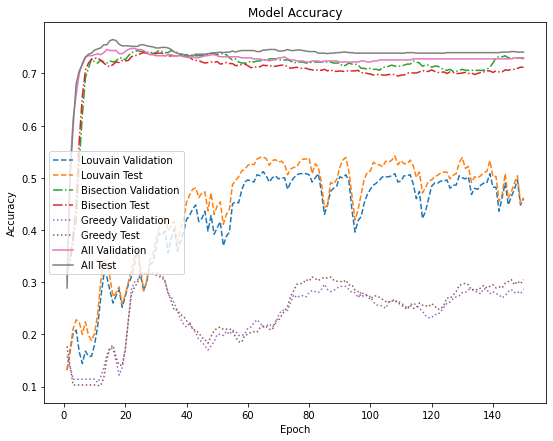

In [33]:
import numpy as np
from matplotlib import pyplot as plt

louvain_results = np.array(louvain_accs)
bisection_results = np.array(bisection_accs)
greedy_results = np.array(greedy_accs)
all_results = np.array(all_accs)

x = np.arange(1, 151)

plt.figure(figsize=(9, 7))

plt.plot(x, louvain_results[:, 1], ls='--', label="Louvain Validation")
plt.plot(x, louvain_results[:, 2], ls='--', label="Louvain Test")
plt.plot(x, bisection_results[:, 1], ls='-.', label="Bisection Validation")
plt.plot(x, bisection_results[:, 2], ls='-.', label="Bisection Test")
plt.plot(x, greedy_results[:, 1], ls=':', label="Greedy Validation")
plt.plot(x, greedy_results[:, 2], ls=':', label="Greedy Test")
plt.plot(x, all_results[:, 1], label="All Validation")
plt.plot(x, all_results[:, 2], label="All Test")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()